# Q-Explorer 

So q-learning is pretty impressive, it is a very general algorithm that can find optimal solutions... however, when we really consider our particular problem, it is, well, kinda bad. The agent keeps throwing itself into the same traps, it keeps hitting walls and going nowhere. So, how can we make it better? The idea here will be quite simple, the agent will build a map(here I mean a literal map, not a function) of the world and will use it to avoid making stupid mistakes(like a reasonable explorer would). To make this idea simple **we will assume a deterministic setting for this agent**.

We will build a policy very similar to q-learning, except that, before taking any step, we will consider what we already mapped and use it to filter actions that are clearly bad. So every time the agent takes a step it will do the following: 
- update the map, considering whether he hit a wall, a trap, or a normal square 
- use this partial map to determine a function of reasonable actions $$A_r: S \to \mathbb{P}(A)$$ that takes each state ($S$) to a set of reasonable actions. just as $Q$ just function is updated at each time step, and maintained between episodes.
- update its Q-function by:
$$ Q(s, a) \leftarrow Q(s_{t}, a_{t}) + \alpha(R_t + \gamma*max_{a \in A_r(s_{t+1})}Q(s_{t+1}, a) - Q(s_{t}, a_{t}))$$ 
- update exploration policy, using $\epsilon-$greedy rule over $$W = \bigcup_{s \in S} s \times A_r(s)$$ for each states(actions over unvisited states are choosen randonly, but are still taken over $A_r(s)$)

This is quite a simple idea, however it is important to notice that this is not nearly as general as an algorithm like q-learning. Here we are using knowledge of how our world behaves, i.e. we know that if an agent on state (0,1) hit a wall going right, then he would do so every time; moreover, he would hit the same wall going down from state (1,2) or left from (0,3). 

In fact in order to apply this to any situation what we need is a form of building the function $A_r$. This is a way to make the agent only look at subspace of $W \subseteq S \times A$, making $Q_{|W}$ what we really need to learn, which can be much easier.

Computationaly this can be much worse then Q-learning, in particular because at each step $t$ we need to update the map and $A_r$ and consequently the policy needs to be updated everywhere, not only at $s_t$. It also does seem reasonable to update the policy only at $s_t$ if we are focused on computational efficiency; however this is not the focus here, as we are interested in "data" efficiency.

In our case, we are taking advantage of being in a deterministic environment as well as the fact that we know the possible effects of our actions pretty well(even if we never taken then) to build $A_r$.

In [1]:
import sys

sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt

from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.agents.q_explorer_agent import QExplorerAgent
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from grid_world.utils.returns import returns_from_reward
from grid_world.utils.policy import get_policy_rec, get_random_policy, sample_action
from notebooks.utils.worlds import small_world_03
from notebooks.utils.basics import basic_actions, basic_reward
from notebooks.utils.experimentation import (
    get_exp_results,
    get_results,
    moving_average,
    get_summary_df,
)


np.random.seed(13)

In [2]:
alpha = 0.7
epsilon = 0.01
gworld = small_world_03
print(get_world_str(gworld))

6                ✘ 

5 ☠  ☠     █     █ 

4          █       

3    ☠  ☠  █  █    

2                  

1    █  █  █  █    

0 ⚐                

  0  1  2  3  4  5 


In [3]:
agent = QExplorerAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=0.7,
    epsilon=0.1,
)


episode_lengths, episode_returns = agent.train(world=gworld, episodes=50)
pi_r = get_policy_rec(agent.policy, small_world_03, agent.actions)

print(get_policy_rec_str(pi_r, small_world_03))

 →  →  →  →  →  ✘ 

 ☠  ☠  ↑  █  ↑  █ 

 →  →  ↑  █  ↑  ← 

 ↑  ☠  ☠  █  █  ↑ 

 ↑  →  →  →  ←  ↑ 

 ↑  █  █  █  █  ↑ 

 ↑  →  →  →  →  ↑ 




## Hyperparameters

These are the same as Q-learning, so lets just take a quick look at how they behave.

In [4]:
training_rounds = 100
episodes = 200

base_arguments = {"reward_function": basic_reward, "actions": basic_actions}
arguments = {"alpha": [0.1, 0.3, 0.7, 1], "epsilon": [0.001, 0.003, 0.01]}

results = get_exp_results(
    QExplorerAgent, gworld, base_arguments, arguments, episodes, training_rounds
)

results_df = get_summary_df(results)
display(
    results_df.round(
        {
            "average_round_reward": 2,
            "std_round_reward": 2,
            "average_reward_final_10": 2,
            "std_reward_final_10": 2,
        }
    )
)

,alpha,epsilon,average_round_reward,std_round_reward,average_reward_final_10,std_reward_final_10,shortest_run
9,1.0,0.001,-2955.18,4.36,-11.02,0.23,12
10,1.0,0.003,-2964.92,7.26,-11.07,0.42,12
11,1.0,0.010,-3001.76,12.06,-11.25,0.83,12
6,0.7,0.001,-3089.92,4.17,-11.04,0.29,12
7,0.7,0.003,-3099.18,7.02,-11.08,0.41,12
8,0.7,0.010,-3129.78,10.99,-11.25,0.85,12
3,0.3,0.001,-3643.22,4.40,-11.02,0.19,12
4,0.3,0.003,-3649.78,5.95,-11.05,0.33,12
5,0.3,0.010,-3676.54,10.25,-11.27,0.80,12
0,0.1,0.001,-5574.86,3.48,-12.61,2.17,12


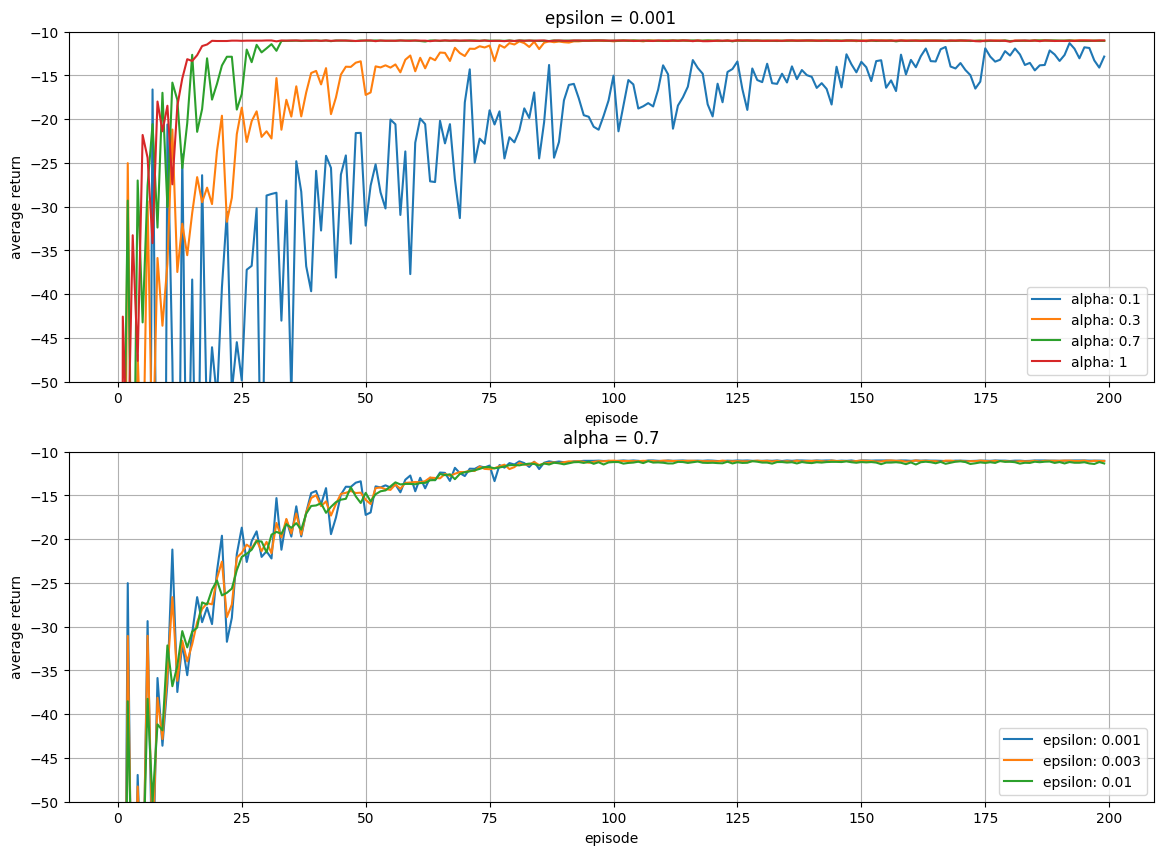

In [5]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in results:
    if params["epsilon"] == 0.001:
        axs[0].plot(
            np.mean(np.array(values[0]), axis=0), label=f'alpha: {params["alpha"]}'
        )

axs[0].set(xlabel="episode", ylabel="average return", ylim=[-50, -10])
axs[0].grid()
axs[0].legend(loc="lower right")
axs[0].set_title("epsilon = 0.001")

for (params, values) in results:
    if params["alpha"] == 0.3:
        axs[1].plot(
            np.mean(np.array(values[0]), axis=0), label=f'epsilon: {params["epsilon"]}'
        )

axs[1].set(xlabel="episode", ylabel="average return", ylim=[-50, -10])
axs[1].grid()
axs[1].legend(loc="lower right")
axs[1].set_title("alpha = 0.7")


plt.show()

This looks pretty good in comparison to q-learning. In particular we can see that the exploration rate doesn't affect performance much, since the agent is not exploring the "bad" actions. 